## Biogas plant

You want to plan the two-year supply of raw materials for a biogas power plant. Such a plant produces energy by burning biogas, which is obtained from the bacterial fermentation of organic wastes. 
Specifically, your plant is powered by corn chopping, a residual of agro-industrial operations that you can purchase from 5 local farms. 
The table below shows the quarterly capacity of each farm for the next two years. Quantities are measured in tons.

Farm|T1|T2|T3|T4|T5|T6|T7|T8
:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:
1|700|1500|700|0|0|700|1500|0
2|1350|0|450|0|1350|0|450|0
3|0|1500|1500|0|0|1500|1500|0
4|820|1560|820|0|820|1560|820|0
5|0|680|1080|0|0|680|1080|0

Due to crop rotations and corn harvesting periods, farms are unable to supply material in some quarters. Moreover the types of corn chopping provided are different, each coming with its own unitary purchase price, unitary storage cost and percentage of dry matter. The table below shows a summary of these information.

Farm|Purchase price|Storage cost|Dry matter
:-|:-:|:-:|:-:
1|0.20|0.002|15
2|0.18|0.012|28
3|0.19|0.007|35
4|0.21|0.011|37
5|0.23|0.015|42

Your biogas plant must operate by burning a mixture of corn choppings with a dry matter percentage between 20% and 40%. Under these conditions, the yield is 421.6 kWh of energy per ton of burned material. The energy produced by the plant is sold on the market at a price of 0.28 $/kWh. 

Due to state regulations, all biogas plants can produce a maximum of 1950 MWh of energy per quarter. You are allowed to store corn chopping in a silo, whose total capacity is of 500 tons. 

Plan the supply and inventory of your biogas plant with the goal of maximizing your profits (i.e., revenues minus costs).

In [ ]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mip

farms_production = [
    [ 700, 1500,  700, 0,    0,  700, 1500, 0],
    [1350,    0,  450, 0, 1350,    0,  450, 0],
    [   0, 1500, 1500, 0,    0, 1500, 1500, 0],
    [ 820, 1560,  820, 0,  820, 1560,  820, 0],
    [   0,  680, 1080, 0,    0,  680, 1080, 0]
]

farms_corn_chopping = [
    [0.20, 0.002, 15],
    [0.18, 0.012, 28],
    [0.19, 0.007, 35],
    [0.21, 0.011, 37],
    [0.23, 0.015, 42]
]

F = range(5)
T = range(8)
max_energy_produced = 1950000     # kWh
energy_produced = 421.6             # kWh per ton of burned material
min_dry_matter = 20
max_dry_matter = 40
silos_capacity = 500                # tons
energy_price = 0.28                 # $/kWh

In [ ]:
# MODEL
m = mip.Model()

# VARIABLES
# corn chopping bought for each farm for each quarter
x = [[m.add_var(ub=farms_production[i][j]) for j in T] for i in F]

# quantity of burnt corn chopping
b = [[m.add_var() for j in T] for i in F]

# quantity of stored corn chopping for each farm for each trimester
stored = [[m.add_var() for j in range(9)] for i in F]

In [ ]:
# CONSTRAINTS
# max energy produced
for j in T:
  m.add_constr(mip.xsum(b[i][j] * energy_produced for i in F) <= max_energy_produced)

# silos is empty before the first quarter
for i in F:
  m.add_constr(stored[i][0] == 0)

# silos capacity constraint
for j in T:
  m.add_constr(mip.xsum(stored[i][j + 1] for i in F) <= silos_capacity)

# binding constraints
for i in F:
  for j in T:
    m.add_constr(b[i][j] == x[i][j] + stored[i][j] - stored[i][j + 1])

# dry matter constraint
for j in T:
  m.add_constr(mip.xsum(b[i][j] for i in F) * min_dry_matter <= mip.xsum(b[i][j] * farms_corn_chopping[i][2] for i in F))
  m.add_constr(mip.xsum(b[i][j] for i in F) * max_dry_matter >= mip.xsum(b[i][j] * farms_corn_chopping[i][2] for i in F))

In [ ]:
# OBJECTIVE FUNCTION
m.objective = mip.maximize(mip.xsum(b[i][j] * energy_produced * energy_price for i in F for j in T)\
                   - mip.xsum(x[i][j] * farms_corn_chopping[i][0] for i in F for j in T) \
                   - mip.xsum(stored[i][j] * farms_corn_chopping[i][1] for i in F for j in range(9)))

m.optimize()

In [ ]:
# DATA VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt

# Bought quantities of corn chopping
df_bought = pd.DataFrame([[x[i][j].x for j in T] for i in F], columns = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"])
df_bought.rename(index = {0:"Farm 1", 1:"Farm 2", 2:"Farm 3", 3:"Farm 4", 4:"Farm 5"}, inplace = True)
df_bought_rounded = df_bought.round(decimals=2)

# Burnt quantities of corn chopping
df_burnt = pd.DataFrame([[b[i][j].x for j in T] for i in F], columns = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"])
df_burnt.loc[len(df_burnt)] = [sum(b[i][j].x for i in F) * energy_produced for j in T]                                          # add the produced energy
df_burnt.loc[len(df_burnt)] = [(sum(b[i][j].x * farms_corn_chopping[i][2] for i in F) / sum(b[i][j].x for i in F)) for j in T]  # add the percentage of dry matter
df_burnt.rename(index = {0:"Farm 1", 1:"Farm 2", 2:"Farm 3", 3:"Farm 4", 4:"Farm 5", 5:"Energy produced (kWh)", 6:"Dry matter (%)"}, inplace = True)
df_burnt_rounded = df_burnt.round(decimals=2)

# Stored quantities of corn chopping
df_stored = pd.DataFrame([[abs(stored[i][j].x) for j in range(9)] for i in F], columns = ["T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"])
df_stored.rename(index = {0:"Farm 1", 1:"Farm 2", 2:"Farm 3", 3:"Farm 4", 4:"Farm 5"}, inplace = True)
df_stored_rounded = df_stored.round(decimals=2)

print("Amount of corn chopping bought (in tons)\n")
display(df_bought_rounded)

print("\n\nAmount of corn chopping burnt (in tons)\n")
display(df_burnt_rounded)

print("\n\nAmount of corn chopping stored (in tons)\n")
display(df_stored_rounded)

print(f"\n\nTotal profit: {m.objective_value}")

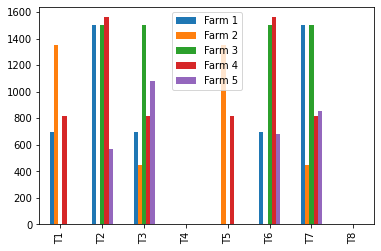

In [ ]:
# PLOTTING
to_plot = df_bought_rounded.transpose()
to_plot.plot.bar()